In [170]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from algorithms import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [171]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    N = tx.shape[0]
    w = np.linalg.solve(np.transpose(tx).dot(tx), np.transpose(tx).dot(y))
    loss = (1 / (2*N)) * np.linalg.norm(y - tx.dot(w))**2
    
    return loss, w

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [190]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    ls_loss, ls_w = least_squares(y, tx)
    
    w0_grid_test = np.linspace(-100, 100, 100)
    w1_grid_test = np.linspace(-100, 100, 100)
    grid_loss, grid_w = grid_search(y, tx, w0_grid_test, w1_grid_test)
    
    initial_w = [0, 0]
    gamma_GD = 0.7
    gamma_GD_mae = 10
    max_iters = 500
    GD_loss, GD_w = gradient_descent(y, tx, initial_w, max_iters, gamma_GD, cost='mse', tol=1e-2, thresh_test_conv=10)
    GD_loss_mae, GD_w_mae = gradient_descent(y, tx, initial_w, max_iters, gamma_GD_mae, cost='mae', tol=1e-2, thresh_test_conv=10)

    gamma_SGD = 0.1
    gamma_SGD_mae = 2
    max_iters = 100
    batch_size = 200
    SGD_loss, SGD_w = stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma_GD, cost='mse', tol=1e-2, thresh_test_conv=10)
    SGD_loss_mae, SGD_w_mae = stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma_GD_mae, cost='mae', tol=1e-2, thresh_test_conv=10)
    
    
    print("ls_w:", ls_w)
    print("grid_w:", grid_w)
    print("GD_w:", GD_w[len(GD_w)-1])
    print("GD_w_mae:", GD_w_mae[len(GD_w_mae)-1])
    print("SGD_w:", SGD_w[len(GD_w_mae)-1])
    print("SGD_w_mae", SGD_w_mae[len(GD_w_mae)-1])
    
    return 0;

Test it here

In [191]:
test_your_least_squares()

Gradient Descent(8/499): loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919, cost: mse
Gradient Descent(18/499): loss=4.424632224699847, w0=73.24, w1=13.526244743050533, cost: mae
Gradient Descent(99/99): loss=15.70282771138647, w0=73.20787708316423, w1=13.06224269206525, cost: mse
Gradient Descent(99/99): loss=4.43287323279368, w0=72.70000000000009, w1=13.295254145525107, cost: mae
ls_w: [ 73.293922    13.47971243]
grid_w: [73.737373737373758, 13.131313131313135]
GD_w: [ 73.29247936  13.47944711]
GD_w_mae: [ 73.24        13.52624474]
SGD_w: [ 72.44365677  13.19076508]
SGD_w_mae [ 74.6         14.27883668]


0

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [71]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [89]:
x

array([ 0.35237491,  4.8951233 ,  1.86662437,  3.50706129,  3.38087384,
        0.73093728,  3.88562366,  5.65224803,  6.28318531,  2.37137419,
        0.60474982,  3.63324875,  0.85712473,  2.49756165,  1.61424946,
        5.39987312,  6.15699785,  6.0308104 ,  0.47856237,  2.87612401,
        4.51656093,  0.98331219,  1.10949964,  0.1       ,  2.11899928,
        1.36187455,  4.01181111,  5.77843549,  4.26418602,  1.2356871 ,
        2.24518674,  1.99281183,  1.48806201,  4.64274839,  4.39037348,
        3.00231147,  0.22618746,  5.27368567,  5.02131076,  5.52606058,
        2.6237491 ,  4.76893584,  3.12849893,  1.74043692,  3.7594362 ,
        3.25468638,  5.90462294,  4.13799857,  2.74993656,  5.14749821])

In [82]:
a = np.array([[1, 2], [4, 5]])
b = np.array([3, 4])
c = np.array([7, 8])
a=np.c_[a, b]
a = np.c_[a, c]
a**2

array([[ 1,  4,  9, 49],
       [16, 25, 16, 64]])

In [192]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # Exception handling if x has only one column: cannot call x.shape[1]
    try:
        D = x.shape[1]
    except IndexError:
        D = 1
        
    N = x.shape[0]
    
    # First column is offset column of 1
    tx = np.ones(N)
    for d in range(degree):
        tx = np.c_[tx, x**(d+1)]
            
    return tx
    

In [193]:
build_poly(x, 3)[:3]

array([[  1.00000000e+00,   3.52374910e-01,   1.24168077e-01,
          4.37537150e-02],
       [  1.00000000e+00,   4.89512330e+00,   2.39622321e+01,
          1.17298081e+02],
       [  1.00000000e+00,   1.86662437e+00,   3.48428655e+00,
          6.50385420e+00]])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [194]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        
        tx = build_poly(x, degree)
        #raise NotImplementedError
        
        loss, w = least_squares(y, tx)
        
        rmse = np.sqrt(2 * compute_loss(y, tx, w, cost = "mse"))
        #raise NotImplementedError

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, w, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773751
Processing 3th experiment, degree=7, rmse=0.24965870360907375
Processing 4th experiment, degree=12, rmse=0.24328247481248674


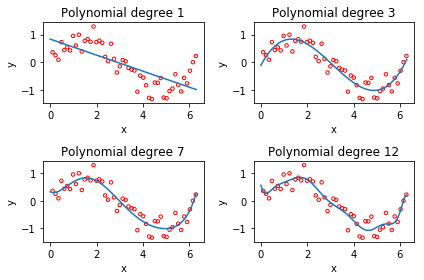

In [195]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [116]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    
    N = x.shape[0]
    
    shuffle_indices = np.random.permutation(np.arange(N))
    shuffled_y = y[shuffle_indices]
    shuffled_x = x[shuffle_indices]
    
    split_index = round(N * ratio);
    
    y_train = shuffled_y[:split_index]
    x_train = shuffled_x[:split_index]
    
    y_val = shuffled_y[split_index:]
    x_val = shuffled_x[split_index:]
    
    return [x_train, y_train], [x_val, y_val]

Then, test your `split_data` function below.

In [120]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    train_set, val_set = split_data(x, y, ratio, seed)
    
    x_train = train_set[0]
    x_val = val_set[0]
    
    y_train = train_set[1]
    y_val = val_set[1]
    
    tx_train = build_poly(x_train, degree)
    tx_val = build_poly(x_val, degree)
        
    loss, w = least_squares(y_train, tx_train)
    
    train_loss = compute_loss(y_train, tx_train, w, cost = "mse")
    val_loss = compute_loss(y_val, tx_val, w, cost = "mse")
    
    rmse_tr = np.sqrt(2 * train_loss)
    rmse_te = np.sqrt(2 * val_loss)

    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [123]:
x.shape[0]*0.1

5.0

In [124]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.548
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.254
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=4.651


# 3 Ridge Regression
Please fill in the function below.

In [125]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N = tx.shape[0]
    D = tx.shape[1]
    lambda_prime = lambda_ * 2 * N
    I = np.diag(np.ones(D))
    w = np.linalg.solve(np.transpose(tx).dot(tx) + lambda_prime * I, np.transpose(tx).dot(y))
    loss = (1 / (2*N)) * np.linalg.norm(y - tx.dot(w))**2 + lambda_ * np.linalg.norm(w)**2
    
    return loss, w

In [198]:
# Apparently running using mse or ridge cost function to estimate the lambda needed is the same
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 100)
    
    [x_train, y_train], [x_val, y_val] = split_data(x, y , ratio, seed)
    
    tx_train = build_poly(x_train, degree)
    tx_val = build_poly(x_val, degree)
    
    rmse_tr = []
    rmse_te = []
    rmse_min = 1;
    for ind, lambda_ in enumerate(lambdas):
        loss, w = ridge_regression(y_train, tx_train, lambda_)
        
        rmse_tr += [np.sqrt(2 * compute_loss(y_train, tx_train, w, cost = "ridge", lambda_ = lambda_))]
        rmse_te += [np.sqrt(2 * compute_loss(y_val, tx_val, w, cost = "ridge", lambda_ = lambda_))]
        
        if (rmse_te[len(rmse_te)-1] <= rmse_min):
            rmse_min = rmse_te[len(rmse_te)-1]
            lambda_min = lambda_
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    print("lambda min:", lambda_min)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, 

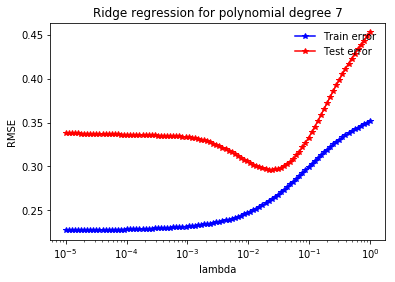

In [199]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)